# Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import random
from pprint import pprint

%matplotlib inline

In [2]:
# change this variable to change the maximum depth of the decision tree formed
MAX_DEPTH = 5

# Dataset splitting

In [3]:
#function to split the dataframe into train, cross-validation and test set
def train_cv_test_split(df, train_size, cv_size):
    n = len(df.index)
    
    train_size = (int)(n * train_size / 100)
    cv_size = (int)(n * cv_size / 100)
    
    indices = df.index.tolist()
    train_indices = random.sample(population = indices, k = train_size)
    
    train_set = df.loc[train_indices]
    df = df.drop(train_indices)
    
    indices = df.index.tolist()
    cv_indices = random.sample(population = indices, k = cv_size)
    
    cv_set = df.loc[cv_indices]
    test_set = df.drop(cv_indices)
    
    return train_set, cv_set, test_set

# Helper functions for building the decision tree 

In [4]:
#function to check if all the data points belong to a single class
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [5]:
#function to return the majority class in a dataframe
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts = True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [6]:
#function to get the all the unique values of all the attributes as potential splits of the dataset
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [7]:
#function to split a dataset based on a given value of a given attribute
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]
    data_below = data[split_column_values == split_value]
    data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [8]:
#function to determine entropy of the dataset
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts = True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [9]:
#function to calculate the total entropy of the split dataset
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [10]:
#function to determine best attribute and its value for splitting the dataset 
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

# Function to build decision tree

In [11]:
def decision_tree_algorithm(df, counter = 0, max_depth = 5):
    
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (counter == max_depth):
        classification = classify_data(data)
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        
        question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

# Accuracy Calculations

In [12]:
#function to classify a single new example using a given decision tree
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    if str(example[feature_name]) == value:
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [13]:
#function to calculate accuracy of tree on the given test set
def calculate_accuracy(df, tree):
    
    if(isinstance(tree, str)):
        total_examples = df.shape[0]
        matching_examples = df[df["label"] == tree]["label"].shape[0]
        accuracy = matching_examples / total_examples
    else:    
        df["classification"] = df.apply(classify_example, axis = 1, args = (tree,))
        df["classification_correct"] = df["classification"] == df["label"]

        accuracy = df["classification_correct"].mean()
    
    return accuracy

# Helper functions to post-prune a decision tree

In [14]:
#function to classify a single new example using a given decision tree
def predict_example(example, tree):
    
    # tree is just a root node
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [15]:
#function to classify a test set based on the given decision tree
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args = (tree,), axis = 1)
    else:
        predictions = pd.Series([], dtype = pd.StringDtype())
        
    return predictions


In [16]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()

    df_yes = df[df[feature].astype(str) == value]
    df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [17]:
def determine_leaf(df_train):
    return df_train.label.value_counts().index[0]

In [18]:
def determine_errors(df_val, tree):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    
    return sum(predictions != actual_values)

In [19]:
def pruning_result(tree, df_train, df_val):
    
    leaf = determine_leaf(df_train)
    errors_leaf = determine_errors(df_val, leaf)
    errors_decision_node = determine_errors(df_val, tree)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

# Function to post-prune a decision tree

In [20]:
#function to post-prune a given tree using given train and cross validation set
def post_pruning(tree, df_train, df_val):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val)

# Loading and preparing data

In [21]:
df = pd.read_csv("breast-cancer.data", names = ['Class','age','menopause','tumor_size','inv_nodes','node_caps','deg_malig','breast','breast_quad','irradiat'])
df["label"] = df.Class
df = df.drop(["Class"], axis = 1)

mode_node_caps = df.node_caps.mode()[0]
mode_breast_quad = df.breast_quad.mode()[0]

df['node_caps'] = df['node_caps'].replace(['?'], mode_node_caps)
df['breast_quad'] = df['breast_quad'].replace(['?'], mode_breast_quad)

# Creating 10 random 60/20/20 splits on the dataset

In [22]:
train_set, cv_set, test_set = [], [], []

for i in range(10):
    train, cv, test = train_cv_test_split(df, 60, 20)
    train_set.append(train)
    cv_set.append(cv)
    test_set.append(test)

# Building tree and calculating accuracy

In [23]:
# evaluating average accuracy over 10 random 60/20/20 splits
mean_accuracy = 0.0
best_accuracy = 0.0
best_accuracy_index = 0

for i in range(10):
    if MAX_DEPTH != -1:
        tree = decision_tree_algorithm(train_set[i], max_depth = MAX_DEPTH)
    else:
        tree = decision_tree_algorithm(train_set[i], max_depth = 10000000)
    accuracy = calculate_accuracy(test_set[i], tree)
    
    if(best_accuracy <= accuracy):
        best_accuracy = accuracy
        best_accuracy_index = i
    
    print("Accuracy of split no. ", i + 1, " = ", accuracy)
    mean_accuracy += accuracy

Accuracy of split no.  1  =  0.7931034482758621
Accuracy of split no.  2  =  0.7241379310344828
Accuracy of split no.  3  =  0.7586206896551724
Accuracy of split no.  4  =  0.603448275862069
Accuracy of split no.  5  =  0.7931034482758621
Accuracy of split no.  6  =  0.8275862068965517
Accuracy of split no.  7  =  0.6896551724137931
Accuracy of split no.  8  =  0.7413793103448276
Accuracy of split no.  9  =  0.6379310344827587
Accuracy of split no.  10  =  0.7931034482758621


In [24]:
print("Average accuracy = ", mean_accuracy / 10)

Average accuracy =  0.7362068965517242


# Best depth limit calculation

In [25]:
depths = range(1, 16)
accuracies = []

for depth in depths:
    tree = decision_tree_algorithm(train_set[best_accuracy_index], max_depth = depth)
    
    accuracy = calculate_accuracy(test_set[best_accuracy_index], tree)
    accuracies.append(accuracy)

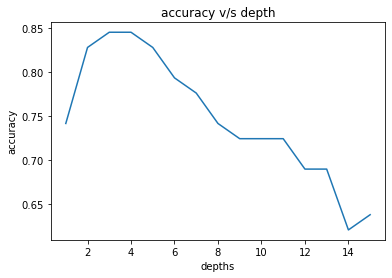

In [26]:
# Plotting graph for accuracy v/s depth to find best possible split
plt.xlabel("depths")
plt.ylabel("accuracy")
plt.title("accuracy v/s depth")
plt.plot(depths, accuracies)

# Post-pruning tree

In [27]:
# finding the depth at which we have maximum accuracy
optimal_accuracy = 0;
optimal_depth = 0;

for depth in depths:
    if(accuracies[depth - 1] > optimal_accuracy):
        optimal_accuracy = accuracies[depth - 1]
        optimal_depth = depth
        
# tree obtained from part 2 having maximum accuracy in the graph is evaluated here
tree = decision_tree_algorithm(train_set[best_accuracy_index], max_depth = optimal_depth)

In [28]:
print("The tree without pruning")
pprint(tree, width = 50)

The tree without pruning
{'deg_malig = 3': [{'inv_nodes = 0-2': [{'breast_quad = right_up': ['recurrence-events',
                                                                    'no-recurrence-events']},
                                        'recurrence-events']},
                   'no-recurrence-events']}


In [29]:
print("Accuracy without pruning:", calculate_accuracy(test_set[best_accuracy_index], tree))

Accuracy without pruning: 0.8448275862068966


In [30]:
tree_pruned = post_pruning(tree, train_set[best_accuracy_index], cv_set[best_accuracy_index])

# Final pruned tree

In [31]:
print("Accuracy with pruning:", calculate_accuracy(test_set[best_accuracy_index], tree_pruned))

Accuracy with pruning: 0.8275862068965517


In [32]:
print("The final decision tree is")
pprint(tree_pruned, width = 50)

The final decision tree is
{'deg_malig = 3': [{'inv_nodes = 0-2': ['no-recurrence-events',
                                        'recurrence-events']},
                   'no-recurrence-events']}
